<a href="https://colab.research.google.com/github/faizdifak/Big-Data/blob/main/Pertemuan_9_Spark_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark findspark


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Tugas 1
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Tes").getOrCreate()

data = [
    ('Agus', 20, 'L', 2000, 2),
    ('Ratih', 17, 'P', 3000, 1),
    ('Roni', 22, 'L', 2500, 2),
    ('Masha', 18, 'P', 3500, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
| Agus| 20|     L|  2000|     2|
|Ratih| 17|     P|  3000|     1|
| Roni| 22|     L|  2500|     2|
|Masha| 18|     P|  3500|     1|
+-----+---+------+------+------+

+-----+---+
| Name|Age|
+-----+---+
|Masha| 18|
+-----+---+

+-----------+
|avg(Salary)|
+-----------+
|     2750.0|
+-----------+



In [ ]:
# Tugas 2
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     P|       3000| 17|
|     P|       3500| 18|
|     L|       2000| 20|
|     L|       2500| 22|
+------+-----------+---+



In [ ]:
# Tugas Tambahan
# 1. Cari rata rata gaji per Departemen
spark.sql("""
    SELECT DeptId, AVG(Salary) AS RataRataGaji
    FROM employees
    GROUP BY DeptId
""").show()


+------+------------+
|DeptId|RataRataGaji|
+------+------------+
|     1|      3250.0|
|     2|      2250.0|
+------+------------+



In [ ]:
# 2. Temukan Karyawan yg Memiliki gaji di atas rata-rata untuk gender masing-masing
spark.sql("""
    SELECT
        e.Name,
        e.Gender,
        e.Salary,
        avg_gender.AvgSalaryPerGender
    FROM employees e
    JOIN (
        SELECT Gender, AVG(Salary) AS AvgSalaryPerGender
        FROM employees
        GROUP BY Gender
    ) avg_gender
    ON e.Gender = avg_gender.Gender
    WHERE e.Salary > avg_gender.AvgSalaryPerGender
""").show()


+-----+------+------+------------------+
| Name|Gender|Salary|AvgSalaryPerGender|
+-----+------+------+------------------+
| Roni|     L|  2500|            2250.0|
|Masha|     P|  3500|            3250.0|
+-----+------+------+------------------+



In [ ]:
# 3 Buat Ranking Karyawan berdasarkan gaji dalam depatemen mereka
spark.sql("""
    SELECT
        Name,
        DeptId,
        Salary,
        RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankGaji
    FROM employees
""").show()


[Stage 19:>                                                         (0 + 1) / 1]

+-----+------+------+--------+
| Name|DeptId|Salary|RankGaji|
+-----+------+------+--------+
|Masha|     1|  3500|       1|
|Ratih|     1|  3000|       2|
| Roni|     2|  2500|       1|
| Agus|     2|  2000|       2|
+-----+------+------+--------+



In [ ]:
# Tugas 3
spark.sql("""
    SELECT
        Name,
        Age,
        Salary,
        CASE
            WHEN Age < 20 THEN 'Remaja'
            WHEN Age BETWEEN 20 AND 24 THEN 'Dewasa Muda'
            ELSE 'Dewasa'
        END AS AgeGroup,
        ROW_NUMBER() OVER (
            PARTITION BY
                CASE
                    WHEN Age < 20 THEN 'Remaja'
                    WHEN Age BETWEEN 20 AND 24 THEN 'Dewasa Muda'
                    ELSE 'Dewasa'
                END
            ORDER BY Salary DESC
        ) AS RankDalamUsia
    FROM employees
""").show()


+-----+---+------+-----------+-------------+
| Name|Age|Salary|   AgeGroup|RankDalamUsia|
+-----+---+------+-----------+-------------+
| Roni| 22|  2500|Dewasa Muda|            1|
| Agus| 20|  2000|Dewasa Muda|            2|
|Masha| 18|  3500|     Remaja|            1|
|Ratih| 17|  3000|     Remaja|            2|
+-----+---+------+-----------+-------------+



In [ ]:
# Tugas 3
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees ''').show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|Ratih| 17|  3000|   1|
|Masha| 18|  3500|   1|
| Agus| 20|  2000|   1|
| Roni| 22|  2500|   1|
+-----+---+------+----+



In [ ]:
# Tugas 4
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('Ridho', 25, 'L', 3500, 1),
    ('Annies', 38, 'L', 4500, 2),
    ('Bahlil', 33, 'L', 2200, 1),
    ('Citra', 20, 'P', 5000, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

25/10/23 20:08:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

+------+---+---------+-----------+
|  Name|Age| DeptName|ProjectName|
+------+---+---------+-----------+
|Bahlil| 33|       HR|  Project A|
| Ridho| 25|       HR|  Project A|
| Citra| 20|Marketing|  Project B|
|Annies| 38|Marketing|  Project B|
+------+---+---------+-----------+



In [ ]:
# Tugas 5
spark.sql("""
SELECT
    e.Name,
    e.Age,
    d.DeptName,
    e.Salary,
    ROUND(AVG(e.Salary) OVER (PARTITION BY e.DeptId), 2) AS AvgSalaryDept,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, SalaryRank
""").show()


[Stage 48:>                                                         (0 + 1) / 1]

+------+---+---------+------+-------------+----------+
|  Name|Age| DeptName|Salary|AvgSalaryDept|SalaryRank|
+------+---+---------+------+-------------+----------+
| Ridho| 25|       HR|  3500|       2850.0|         1|
|Bahlil| 33|       HR|  2200|       2850.0|         2|
| Citra| 20|Marketing|  5000|       4750.0|         1|
|Annies| 38|Marketing|  4500|       4750.0|         2|
+------+---+---------+------+-------------+----------+



In [ ]:
# Tugas 6
spark.sql("""
SELECT
    e.Name,
    e.Age,
    d.DeptName,
    e.Salary,
    LAG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS PrevSalary,
    LEAD(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS NextSalary,
    ROUND(
        e.Salary - LAG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age),
        2
    ) AS SalaryChange
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, e.Age
""").show()


+------+---+---------+------+----------+----------+------------+
|  Name|Age| DeptName|Salary|PrevSalary|NextSalary|SalaryChange|
+------+---+---------+------+----------+----------+------------+
| Ridho| 25|       HR|  3500|      NULL|      2200|        NULL|
|Bahlil| 33|       HR|  2200|      3500|      NULL|       -1300|
| Citra| 20|Marketing|  5000|      NULL|      4500|        NULL|
|Annies| 38|Marketing|  4500|      5000|      NULL|        -500|
+------+---+---------+------+----------+----------+------------+



In [ ]:
pip install matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 606.5 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 208.3 kB/s eta 0:00:00 kB/s eta 0:00:01:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 581.8 kB/s eta 0:00:001m999.2 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 779.9 kB/s eta 0:00:001m781.7 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ourpy]
Note: you may need to restart the kernel to use updated packages.


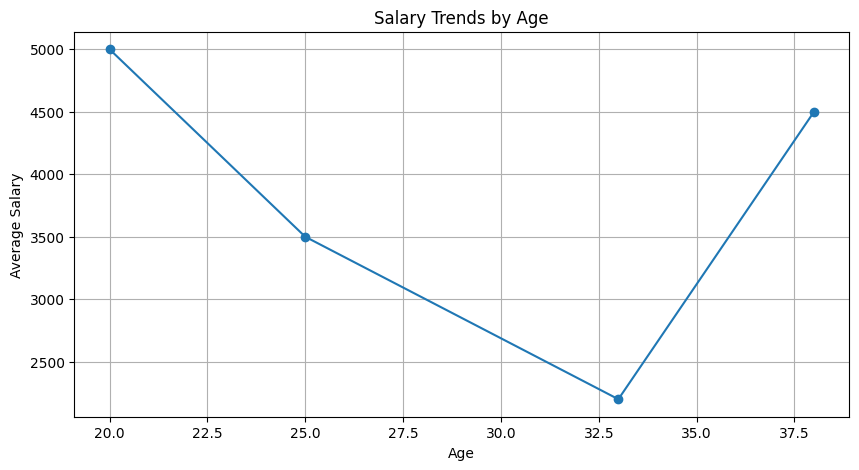

In [ ]:
# Tugas 7
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

25/10/23 20:41:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


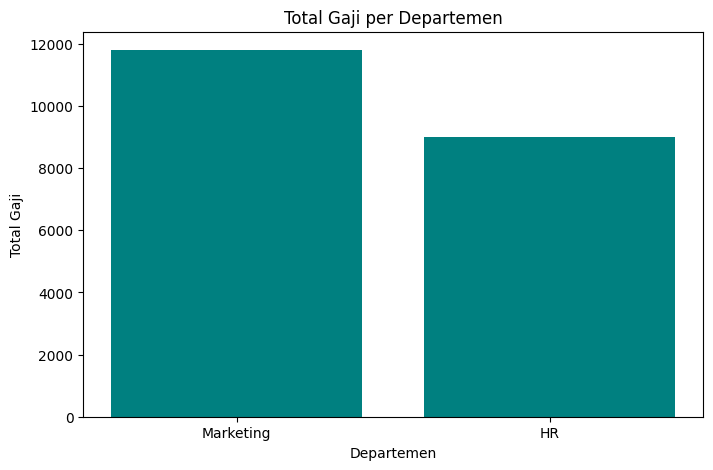

    DeptName  TotalSalary  EmployeeCount
0  Marketing        11800              3
1         HR         9000              3


In [ ]:
# Tugas Homework
#Tugas 1
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Inisialisasi Spark
spark = SparkSession.builder.appName('AnalisisDepartemen').getOrCreate()

# Data contoh
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Siti', 25, 'F', 3500, 2),
    ('Budi', 30, 'M', 3300, 1),
    ('Rina', 26, 'F', 4200, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')

# Query total gaji & jumlah karyawan per departemen
dept_salary = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''').toPandas()

# Visualisasi bar chart
plt.figure(figsize=(8, 5))
plt.bar(dept_salary['DeptName'], dept_salary['TotalSalary'], color='teal')
plt.title('Total Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.show()

print(dept_salary)


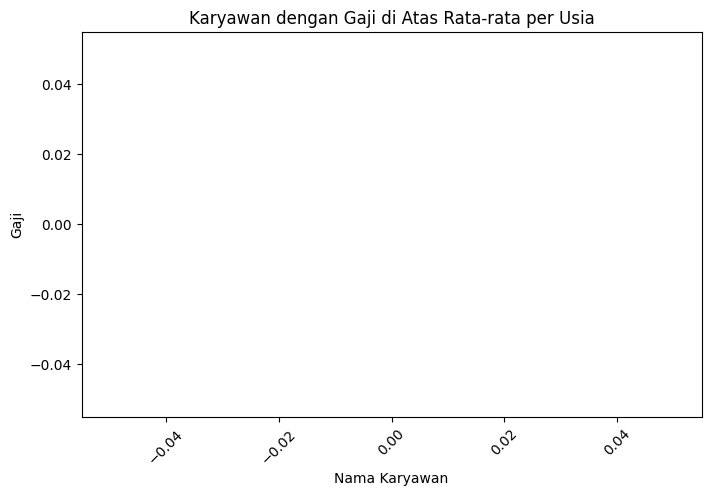

Empty DataFrame
Columns: [Name, Age, Salary]
Index: []


In [ ]:
#Tugas 2
# Buat view dari sebelumnya
employees.createOrReplaceTempView('employees')

# Query Spark SQL
above_avg = spark.sql('''
WITH avg_salary_per_age AS (
    SELECT Age, AVG(Salary) AS avg_salary
    FROM employees
    GROUP BY Age
)
SELECT e.Name, e.Age, e.Salary
FROM employees e
JOIN avg_salary_per_age a ON e.Age = a.Age
WHERE e.Salary > a.avg_salary
ORDER BY e.Age
''').toPandas()

# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(above_avg['Name'], above_avg['Salary'], color='orange')
plt.title('Karyawan dengan Gaji di Atas Rata-rata per Usia')
plt.xlabel('Nama Karyawan')
plt.ylabel('Gaji')
plt.xticks(rotation=45)
plt.show()

print(above_avg)



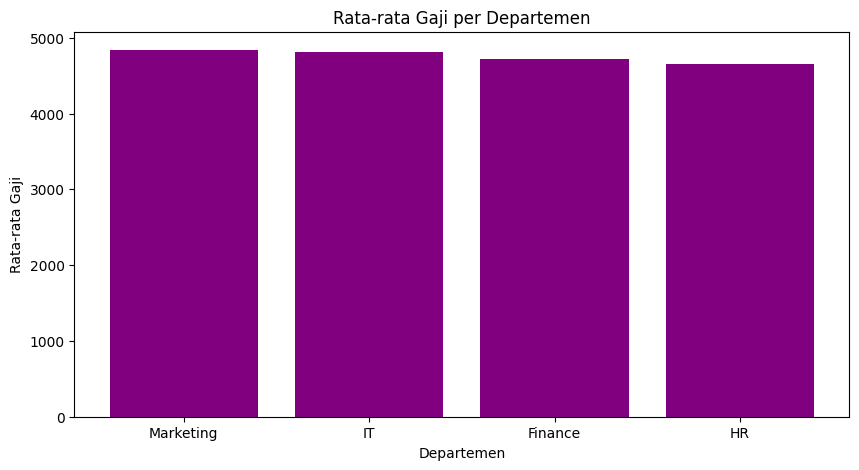

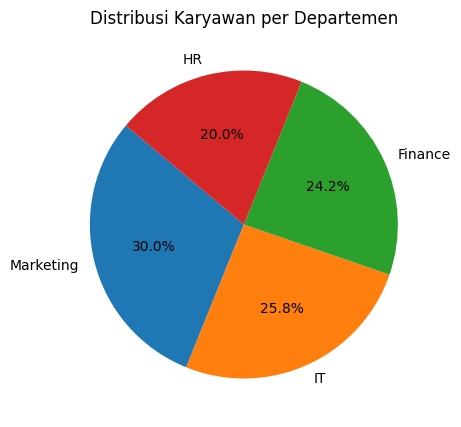

    DeptName  TotalEmployees  AvgSalary  TotalSalary
0  Marketing              36    4837.06       174134
1         IT              31    4814.87       149261
2    Finance              29    4722.76       136960
3         HR              24    4647.75       111546


In [ ]:
# Tugas 3
import random

# Buat dataset besar
data = []
departments_data = [(1, 'HR'), (2, 'Marketing'), (3, 'Finance'), (4, 'IT')]
for i in range(1, 121):  # 120 data
    name = f'Emp_{i}'
    age = random.randint(22, 50)
    gender = random.choice(['M', 'F'])
    salary = random.randint(2500, 7000)
    dept = random.choice([1, 2, 3, 4])
    data.append((name, age, gender, salary, dept))

employees_big = spark.createDataFrame(data, ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments_big = spark.createDataFrame(departments_data, ['DeptId', 'DeptName'])

employees_big.createOrReplaceTempView('employees_big')
departments_big.createOrReplaceTempView('departments_big')

# Analisis mendalam: rata-rata, total, dan jumlah per departemen
analysis = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) AS TotalEmployees,
       ROUND(AVG(e.Salary), 2) AS AvgSalary,
       SUM(e.Salary) AS TotalSalary
FROM employees_big e
JOIN departments_big d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AvgSalary DESC
''').toPandas()

# Visualisasi multi-chart
plt.figure(figsize=(10, 5))
plt.bar(analysis['DeptName'], analysis['AvgSalary'], color='purple')
plt.title('Rata-rata Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Rata-rata Gaji')
plt.show()

plt.figure(figsize=(10, 5))
plt.pie(analysis['TotalEmployees'], labels=analysis['DeptName'], autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Karyawan per Departemen')
plt.show()

print(analysis)
